In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn_modcall as adeq
from src.advec_diff_case.AD_Eqn_Helper_Classes import * 

import time
import sys
import os
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy as spy

tf.keras.backend.set_floatx('float32')

## Define some useful classes

In [4]:
### Define a custom plotting function
class custom_plot:

    def __init__(self, x, t):
        self.t = t
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x
            
    def plot(self, u, title='Hello', t_max = None):
        fig = plt.figure(figsize=(7, 4.5), facecolor='white')
        ax_u_lowres = fig.add_subplot(111)
        
        ax_u_lowres.cla()
        ax_u_lowres.set_title(title, fontsize=14)
        ax_u_lowres.set_xlabel('x', fontsize=14)
        ax_u_lowres.set_ylabel('t', fontsize=14)
        plot = ax_u_lowres.contourf(self.X, self.T, u, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.5, 40), extend='min')
        ax_u_lowres.set_xlim(self.x[0], self.x[-1])
        if t_max == None:
            ax_u_lowres.set_ylim(self.t[0], self.t[-1])
        else:
            ax_u_lowres.set_ylim(self.t[0], t_max)
        plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)
        
        plt.show

## Main part starts here

## Solve for high-resolution

In [5]:
app = adeq.ad_eqn_args(T = 5.0, nt = 500, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x = tf.linspace(0., app.L, app.nx)
u0 = initial_cond(x, app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

op = adeq.operators(app)

u = ddeinttf(adeq.ad_eqn(op, app), u0, t, alg_name = 'vode', nsteps = -1)

## Solve for low resolution

In [6]:
app_lowres = adeq.ad_eqn_args(T = 5.0, nt = 500, L = 1., nx = 25, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x_lowres = tf.linspace(0., app_lowres.L, app_lowres.nx)
u0_lowres = initial_cond(x_lowres, app_lowres) # Initial conditions
t_lowres = tf.linspace(0., app_lowres.T, app_lowres.nt) # Time array

op_lowres = adeq.operators(app_lowres)

u_lowres = ddeinttf(adeq.ad_eqn(op_lowres, app_lowres), u0_lowres, t_lowres, alg_name = 'vode', nsteps = -1)

## Plots for high-res solution

#### Contour plot

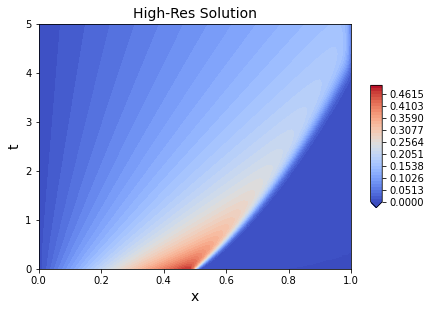

In [7]:
cp = custom_plot(x, t)

cp.plot(tf.squeeze(u, axis=1).numpy(), 'High-Res Solution')

## Plots for high-res interpolated on low-res grid

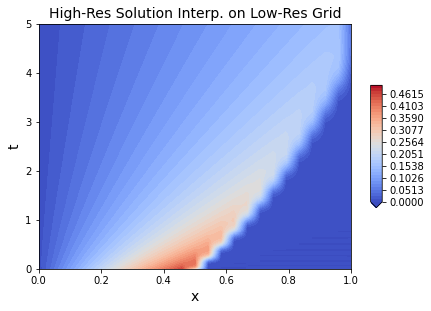

In [8]:
X_lowres, T_lowres = np.meshgrid(x_lowres.numpy(), t_lowres.numpy())
f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

cp = custom_plot(x_lowres, t_lowres)

cp.plot(f(x_lowres, t_lowres), 'High-Res Solution Interp. on Low-Res Grid')

## Plots for low-res solution

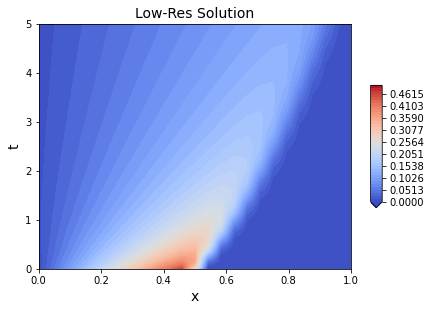

In [9]:
cp = custom_plot(x_lowres, t_lowres)

cp.plot(tf.squeeze(u_lowres, axis=1).numpy(), 'Low-Res Solution')

## Plots for difference between high-res interp and low-res solution

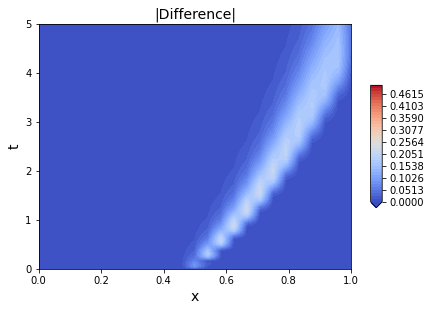

In [10]:
cp = custom_plot(x_lowres, t_lowres)

cp.plot(tf.abs(f(x_lowres, t_lowres) - tf.squeeze(u_lowres, axis=1)).numpy(), '|Difference|')

## Make 2D animation of the moving wave

In [11]:
from matplotlib.animation import FuncAnimation, PillowWriter
from numpy import random 

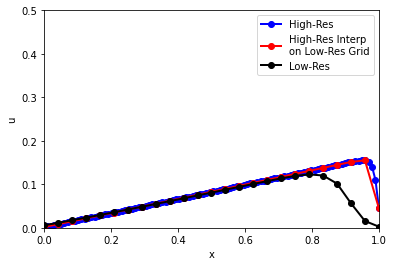

In [12]:
fig, ax = plt.subplots()
line, = plt.plot([], [], 'o-', lw=2)
labels = ['High-Res', 'High-Res Interp \non Low-Res Grid', 'Low-Res']

plotlays, plotcols = [3], ["blue","red", "black"]
lines = []
for index in range(3):
    lobj = ax.plot([],[], 'o-', lw=2,color=plotcols[index])[0]
    lines.append(lobj)

def init():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    
    for line in lines:
        line.set_data([],[])
    return lines

def update(frame):
    xdata = [x.numpy(), x_lowres.numpy(), x_lowres.numpy()]
    ydata = [tf.squeeze(u, axis=1).numpy()[frame, :], f(x_lowres, t_lowres)[frame, :], tf.squeeze(u_lowres, axis=1).numpy()[frame, :]]
    
    for lnum,line in enumerate(lines):
        line.set_data(xdata[lnum], ydata[lnum]) # set data for each line separately.
        line.set_label(labels[lnum])
        ax.legend(loc="upper right")

        fig.gca().autoscale_view()
        fig.gca().relim()
    return lines 

ani = FuncAnimation(fig, update, frames=np.arange(len(t.numpy())),
                    init_func=init, blit=True, interval=60)

ani.save('filename_res.gif', writer=PillowWriter(fps=24))

## Plot high-res solution interp only for the training time

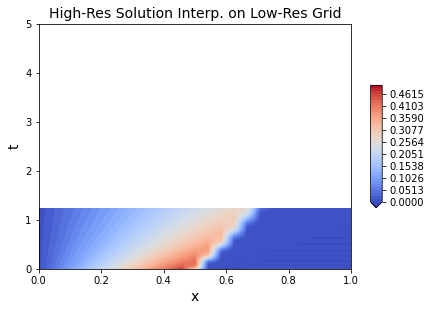

In [13]:
X_lowres, T_lowres = np.meshgrid(x_lowres.numpy(), t_lowres.numpy()[0:int(len(t.numpy())/4)])
f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

cp = custom_plot(x_lowres, t_lowres[0:int(len(t.numpy())/4)])

cp.plot(f(x_lowres, t_lowres[0:int(len(t.numpy())/4)]), 'High-Res Solution Interp. on Low-Res Grid', t_max = t_lowres[-1])

### Compute the Errors

In [14]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*0.02
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

In [15]:
truth = f(x_lowres, t_lowres)
truth = tf.expand_dims(tf.convert_to_tensor(truth, tf.float32), axis=1)

In [16]:
err_obj = compute_error(truth)

In [17]:
np.round(err_obj.l2_error(u_lowres), 2)

array([0.24], dtype=float32)

In [18]:
np.round(err_obj.RMSE(u_lowres), 2)

0.11

In [20]:
import pickle

In [21]:
os.chdir(basedir)

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')
u_lowres_interp_highres = f(x_lowres, t_lowres)

data_dict = {'x_lowres':x_lowres, 't_lowres':t_lowres,
             'u_lowres_interp_highres':u_lowres_interp_highres, 'u_lowres':tf.squeeze(u_lowres, axis=1)}

with open(os.path.join('neuralClosureModels/final_paper_scripts', 'bseline_Exp2.pkl'), 'wb') as output:
    pickle.dump(data_dict, output, pickle.HIGHEST_PROTOCOL)